# Ablation: Semi-Supervised Architope - for Reviews
---
- This code Implements Algorithm 3.2 of the "PC-NNs" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 0.9
min_width = 50
# Ablation Finess
N_plot_finess = 5
# min_parts_threshold = .001; max_parts_threshold = 0.9
N_min_parts = 1; N_max_plots = 4
Tied_Neurons_Q = True

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 10**4

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
#================================================#
 Training Datasize: 539 and test datasize: 60.  
#================================================#
#================================================#
 Training Datasize: 191 and test datasize: 21.  
#================================================#


### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

#### Explicit Partion Builder:
Implements exactly Algorithm 2:

In [7]:
def Random_Lipschitz_Partioner(X_in,
                               y_in,
                               N_parts_to_get=4):

    # Compute Size of each part
    size_part_reference = int(round(X_in.shape[0]/N_parts_to_get))

    # Apply random bijection #
    #------------------------#
    ## Get random bijection indices
    random_bijection_indices = np.random.choice(range(X_in.shape[0]),size=X_in.shape[0], replace=False)
    ## Apply random bijections
    X_in_shuffled = X_in[random_bijection_indices,:]
    y_in_shuffled = y_in[random_bijection_indices,:]

    # Initialize Lists #
    #------------------#
    X_parts = []
    y_parts = []

    for i_th_part_to_get in range(N_parts_to_get):
        # Build random balls #
        #--------------------#
        ## Sample random radius
        size_part = int(np.maximum(1,np.round(size_part_reference*np.random.uniform(low=.5,high=1.5,size=1)[0])))
        ## Sample random point
        X_center_loop_index = np.random.choice(range(X_in_shuffled.shape[0]),size=1, replace=False)
        X_center_loop = X_in_shuffled[X_center_loop_index,:]
        ## Compute Typical Distances from Center
        distances_loop = X_center_loop-X_in_shuffled
        distances_loop = np.linalg.norm(distances_loop, axis=1)

        # Remove Random Ball from Dataset
        if size_part <= len(distances_loop):
            ## Identify indices
            indices_smallest_to_random_ball = np.argsort(distances_loop)[:size_part]
        else:
            print('Final Loop')
            indices_smallest_to_random_ball = np.array(range(X_in_shuffled.shape[0]))
        ## Extract Parts
        X_current_part_loop = X_in_shuffled[indices_smallest_to_random_ball,:]
        y_current_part_loop = y_in_shuffled[indices_smallest_to_random_ball,:]
        ## Append to List of Parts
        X_parts.append(X_current_part_loop)
        y_parts.append(y_current_part_loop)

        # Remove Selected Entries From Array #
        #------------------------------------#
        X_in_shuffled = np.delete(X_in_shuffled,indices_smallest_to_random_ball,axis=0)
        y_in_shuffled = np.delete(y_in_shuffled,indices_smallest_to_random_ball,axis=0)

        # Failsafe if procedure has terminated
        if X_in_shuffled.shape[0] == 0:
            print('breaking early')
            break
    # Count Number of Parts Generated        
    N_parts_generated = len(X_parts)
    # Output Parts
    return X_parts, y_parts, N_parts_generated

# Ablation Function

In [8]:
def get_PCNNs(N_parts,X_train,y_train,X_test,y_test):

    # Initialization(s) #
    #-------------------#
    N_neurons = 0
    L_timer = 0
    P_timer = 0
    Mean_Width_Subnetworks = 0

    # Partitioner Begin #
    #-------------------#
    import time
    partitioning_time_begin = time.time()
    print('-------------------------------------------------------')
    print('Randomly Initialized Parts - Via Randomized Algorithm 2')
    print('-------------------------------------------------------')
    X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(X_train.to_numpy(),
                                                                                         y_train.reshape(-1,1),
                                                                                         N_parts)
    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(N_parts_Generated_by_Algo_2)+'.')
    ############# Partitioner End ########

    print('-----------------------------------------------------')
    print('Training Sub-Networks on Each Randomly Generated Part')
    print('-----------------------------------------------------')
    # Time-Elapse (Start) for Training on Each Part #
    PCNN_timer = time.time(); PCNN_timer = -math.inf; N_params_Architope = 0; N_params_tally = 0
    # Remove Eager Execution Error(s)
    tf.compat.v1.disable_eager_execution()
    # Automatically Initialize Correct Input/Output Dimension(s)
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]; param_grid_Vanilla_Nets['output_dim'] = [1]
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    # Decide if/or not to tie neuron numbers of sub-patterns together
    if Tied_Neurons_Q == True:
        param_grid_Vanilla_Nets['height'] = [int(np.maximum(round(param_grid_Vanilla_Nets['height'][0]/N_parts),min_width))]
        param_grid_Deep_Classifier['height'] = [int(np.maximum(round(param_grid_Deep_Classifier['height'][0]/N_parts),min_width))]

    for current_part in range(N_parts_Generated_by_Algo_2):
        # Update User #
        #-------------#
        print('-----------------------------------------------------------')
        print('Currently Training Part: '+str(current_part)+'/'+str(N_parts_Generated_by_Algo_2 )+'Total Parts.')
        print('-----------------------------------------------------------')

        # Timer for Part
        part_training_timer = time.time()
        # Get Data for Sub-Pattern
        X_loop = pd.DataFrame(X_parts_list[current_part])
        y_loop = (y_parts_list[current_part]).reshape(-1,)
        # Train ffNN
        y_hat_part_loop, y_hat_part_loop_test, N_neurons_PCNN_loop = build_ffNN(n_folds = 4, 
                                                                              n_jobs = n_jobs,
                                                                              n_iter = n_iter, 
                                                                              param_grid_in = param_grid_Vanilla_Nets, 
                                                                              X_train= X_loop, 
                                                                              y_train=y_loop,
                                                                              X_test_partial=X_train,
                                                                              X_test=X_test,
                                                                              NOCV=True)
        # Reshape y
        ## Training
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop.shape = (y_hat_part_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        ## Testing
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop_test.shape = (y_hat_part_loop_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])

        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_part_loop-y_train)).reshape(y_hat_part_loop.shape[0],1)

            # Save Predictions
            predictions_train = y_hat_part_loop.reshape(y_hat_part_loop.shape[0],1)
            predictions_test = y_hat_part_loop_test.reshape(y_hat_part_loop_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_part_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_part_loop_test.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        #==============================#
        # Update Performance Metric(s) #
        #==============================#
        part_training_timer = time.time() - part_training_timer
        # L-Time
        L_timer += partitioning_time
        # P-Time
        P_timer = max(P_timer,part_training_timer)
        # N. Params
        N_neurons += N_neurons_PCNN_loop
        # Mean Width for Sub-Network(s)
        Mean_Width_Subnetworks += param_grid_Vanilla_Nets['height'][0]

    # Take Mean of Width(s)
    Mean_Width_Subnetworks = Mean_Width_Subnetworks/N_parts_Generated_by_Algo_2
    print('-----------------------')
    print('Training Deep Zero-Sets')
    print('-----------------------')


    # Time Elapsed for Training Deep Zero-Sets
    Deep_Zero_Sets_timer = time.time()

    ## Initialize Classes Labels
    partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    ## Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    ## Convert to integers
    partition_labels_training = partition_labels_training+0
    ## Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
    # Get Binary Classes (Discontinuous Unit)
    ## Training Set
    predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
    ## Testing Set
    predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
    # Get PC-NN Prediction(s)
    ## Train
    PCNN_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
    ## Test
    PCNN_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)

    # End Timer
    Deep_Zero_Sets_timer = time.time() - Deep_Zero_Sets_timer

    print('-----------------------------------')
    print('Computing Final Performance Metrics')
    print('-----------------------------------')
    # Time-Elapsed Training Deep Classifier

    # Update Times
    L_timer +=Deep_Zero_Sets_timer
    P_timer +=Deep_Zero_Sets_timer
    # Update Number of Neurons Used
    N_neurons_subPatterns = N_neurons
    N_neurons_deep_Zero_Sets = (param_grid_Deep_Classifier['height'][0])*(param_grid_Deep_Classifier['depth'][0])
    N_neurons = N_neurons_deep_Zero_Sets + N_neurons_subPatterns



    # Compute Peformance
    performance_PCNN = reporter(y_train_hat_in=PCNN_prediction_y_train,y_test_hat_in=PCNN_prediction_y_test,
                                y_train_in=y_train,
                                y_test_in=y_test)
    # Write Performance
    performance_PCNN.to_latex((results_tables_path+"PCNN_full_performance.tex"))

    # Update User
    print(performance_PCNN)

    ### Model Complexity/Efficiency Metrics
    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_neurons - np.log((performance_PCNN['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_neurons) *(performance_PCNN['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    PCNN_Model_Complexity = pd.DataFrame({'L-time': [L_timer],
                                               'P-time':[P_timer],
                                               'N_params_expt': [N_neurons],
                                               'AIC-like': [AIC_like],
                                               'Eff': [Efficiency],
                                               'N. Parts':[N_parts_Generated_by_Algo_2]})


    # Write Required Training Time(s)
    PCNN_Model_Complexity.to_latex((results_tables_path+"PCNN_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(PCNN_Model_Complexity)
    
    
    # Return Output(s)
    return performance_PCNN, PCNN_Model_Complexity, N_parts_Generated_by_Algo_2, N_neurons, N_neurons_subPatterns,N_neurons_deep_Zero_Sets, Mean_Width_Subnetworks

---
# Perform Ablation:
---

In [9]:
# Initialize 
# q_implicit_N_parts_possibilities = np.linspace(min_parts_threshold,max_parts_threshold,N_plot_finess)
N_parts_possibilities = np.unique(np.round(np.linspace(N_min_parts,N_max_plots,num=N_plot_finess))).astype(int)

# Get Performance Metric
for inplicit_N_parts_loop in range(len(N_parts_possibilities)):
    ### UPDATE USER ###
    for k in range(10):
        print('--------------------------------------')
    print('Ablation Completion Percentage:',(inplicit_N_parts_loop/N_plot_finess))
    for k in range(10):
        print('--------------------------------------')
    
    # Implicitly Set: Current Number of Parts
#     q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    N_parts_possibilities_loop = N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, N_neurons_subPatterns_loop, N_neurons_deep_Zero_Sets_loop, height_mean_loop = get_PCNNs(N_parts_possibilities_loop,X_train,y_train,X_test,y_test)
#     performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, height_mean_loop = Ablate_PCNNs(q_implicit_N_parts_loop,data_y,X_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,6,1])

    # Record
    if inplicit_N_parts_loop == 0:
        # Don't count partitioner if only one parts is active!
        if N_parts_possibilities_loop <= 1:
            Architope_Model_Complexity_full_loop[:,1] = Architope_Model_Complexity_full_loop[:,0]
            N_neurons_deep_Zero_Sets_loop = 0
        # Record Model Complexities Otherwise    
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
        N_params_subPatterns_hist = N_neurons_subPatterns_loop
        N_neurons_deep_Zero_Sets_hist = N_neurons_deep_Zero_Sets_loop
        N_params_architope_hist = N_neurons_deep_Zero_Sets_loop + N_neurons_subPatterns_loop
        height_mean_hist = height_mean_loop
        N_neurons_per_input = N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)
        N_params_architope_hist = np.append(N_params_architope_hist,N_params_architope_loop)
        N_params_subPatterns_hist = np.append(N_params_subPatterns_hist,N_neurons_subPatterns_loop)
        N_neurons_deep_Zero_Sets_hist = np.append(N_neurons_deep_Zero_Sets_hist,N_neurons_deep_Zero_Sets_loop)
        height_mean_hist = np.append(height_mean_hist,height_mean_loop)
        N_neurons_per_input = np.append(N_neurons_per_input,(N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))))

# Cleanup
## Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]

# Write
## Prediction Qualities
performance_Architope_history_report_MAE_train = (performance_Architope_history[0,0,:])[get_unique_entries]
performance_Architope_history_report_MAE_test = (performance_Architope_history[0,1,:])[get_unique_entries]
performance_Architope_history_report_MSE_train = (performance_Architope_history[1,0,:])[get_unique_entries]
performance_Architope_history_report_MSE_test = (performance_Architope_history[1,1,:])[get_unique_entries]
## Model Complexities
L_Times = (Architope_Model_Complexity_history[:,1].reshape(-1,))[get_unique_entries]
P_Times = (Architope_Model_Complexity_history[:,0].reshape(-1,))[get_unique_entries]
N_Params = (N_params_architope_hist.reshape(-1,))[get_unique_entries]
mean_subpattern_widths_hist = (height_mean_hist.reshape(-1,))[get_unique_entries]
AIC_Like = (Architope_Model_Complexity_history[:,3].reshape(-1,))[get_unique_entries]
Eff = (Architope_Model_Complexity_history[:,4].reshape(-1,))[get_unique_entries]

--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
Ablation Completion Percentage: 0.0
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
-------------------------------------------------------
Randomly Initialized Parts - Via Randomized Algorithm 2
-------------------------------------------------------
Final Loop
break

191/191 [==============================] - 0s 424us/sample - loss: 394.5102 - mse: 396345.4688 - mae: 394.5102 - mape: 128.5387
Epoch 47/75
191/191 [==============================] - 0s 454us/sample - loss: 393.6317 - mse: 394939.1562 - mae: 393.6317 - mape: 129.3135
Epoch 48/75
191/191 [==============================] - 0s 417us/sample - loss: 392.7336 - mse: 393570.5938 - mae: 392.7336 - mape: 130.2309
Epoch 49/75
191/191 [==============================] - 0s 475us/sample - loss: 391.7226 - mse: 391684.7188 - mae: 391.7226 - mape: 130.6820
Epoch 50/75
191/191 [==============================] - 0s 385us/sample - loss: 390.9238 - mse: 390467.4062 - mae: 390.9238 - mape: 131.9638
Epoch 51/75
191/191 [==============================] - 0s 456us/sample - loss: 389.9541 - mse: 388806.1875 - mae: 389.9541 - mape: 132.4328
Epoch 52/75
191/191 [==============================] - 0s 438us/sample - loss: 388.9524 - mse: 387223.5000 - mae: 388.9524 - mape: 133.3168
Epoch 53/75
191/191 [===========

68/68 [==============================] - 0s 351us/sample - loss: 149.0007 - mse: 41490.6367 - mae: 149.0007 - mape: 117.3728
Epoch 17/75
68/68 [==============================] - 0s 724us/sample - loss: 148.9722 - mse: 41480.5859 - mae: 148.9722 - mape: 117.0848
Epoch 18/75
68/68 [==============================] - 0s 855us/sample - loss: 148.9419 - mse: 41471.0312 - mae: 148.9419 - mape: 116.6346
Epoch 19/75
68/68 [==============================] - 0s 535us/sample - loss: 148.9128 - mse: 41461.2109 - mae: 148.9128 - mape: 116.2337
Epoch 20/75
68/68 [==============================] - 0s 464us/sample - loss: 148.8822 - mse: 41451.3906 - mae: 148.8822 - mape: 115.8660
Epoch 21/75
68/68 [==============================] - 0s 435us/sample - loss: 148.8529 - mse: 41441.4062 - mae: 148.8529 - mape: 115.5536
Epoch 22/75
68/68 [==============================] - 0s 416us/sample - loss: 148.8250 - mse: 41431.8750 - mae: 148.8250 - mape: 115.2564
Epoch 23/75
68/68 [==============================] - 

Train on 64 samples
Epoch 1/75
64/64 [==============================] - 0s 6ms/sample - loss: 504.6740 - mse: 663146.9375 - mae: 504.6740 - mape: 100.4060
Epoch 2/75
64/64 [==============================] - 0s 262us/sample - loss: 504.5352 - mse: 662928.7500 - mae: 504.5352 - mape: 100.3703
Epoch 3/75
64/64 [==============================] - 0s 265us/sample - loss: 504.4081 - mse: 662742.6250 - mae: 504.4081 - mape: 100.3831
Epoch 4/75
64/64 [==============================] - 0s 253us/sample - loss: 504.3008 - mse: 662541.3750 - mae: 504.3008 - mape: 100.5915
Epoch 5/75
64/64 [==============================] - 0s 250us/sample - loss: 504.1833 - mse: 662342.4375 - mae: 504.1833 - mape: 100.6670
Epoch 6/75
64/64 [==============================] - 0s 275us/sample - loss: 504.0647 - mse: 662159.1875 - mae: 504.0647 - mape: 100.8368
Epoch 7/75
64/64 [==============================] - 0s 310us/sample - loss: 503.9526 - mse: 661944.1250 - mae: 503.9526 - mape: 101.0071
Epoch 8/75
64/64 [=====

64/64 [==============================] - 0s 241us/sample - loss: 497.5713 - mse: 651561.0000 - mae: 497.5713 - mape: 108.0731
Epoch 61/75
64/64 [==============================] - 0s 247us/sample - loss: 497.4476 - mse: 651354.1875 - mae: 497.4476 - mape: 108.2043
Epoch 62/75
64/64 [==============================] - 0s 241us/sample - loss: 497.3300 - mse: 651180.1250 - mae: 497.3300 - mape: 108.3075
Epoch 63/75
64/64 [==============================] - 0s 244us/sample - loss: 497.2021 - mse: 650989.1250 - mae: 497.2021 - mape: 108.4872
Epoch 64/75
64/64 [==============================] - 0s 322us/sample - loss: 497.0820 - mse: 650757.1875 - mae: 497.0820 - mape: 108.6503
Epoch 65/75
64/64 [==============================] - 0s 275us/sample - loss: 496.9434 - mse: 650541.5000 - mae: 496.9434 - mape: 108.7776
Epoch 66/75
64/64 [==============================] - 0s 312us/sample - loss: 496.8241 - mse: 650347.8750 - mae: 496.8241 - mape: 108.9239
Epoch 67/75
64/64 [===========================

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/75
44/44 [==============================] - 0s 7ms/sample - loss: 139.1328 - mse: 36974.4336 - mae: 139.1328 - mape: 100.0661
Epoch 2/75
44/44 [==============================] - 0s 410us/sample - loss: 139.1303 - mse: 36973.8398 - mae: 139.1303 - mape: 100.0167
Epoch 3/75
44/44 [==============================] - 0s 244us/sample - loss: 139.1282 - mse: 36973.3086 - mae: 139.1282 - mape: 99.9919
Epoch 4/75
44/44 [==============================] - 0s 210us/sample - loss: 139.1262 - mse: 36972.7930 - mae: 139.1262 - mape: 99.9545
Epoch 5/75
44/44 [==============================] - 0s 247us/sample - loss: 139.1241 - mse: 36972.2969 - mae: 139.1241 - mape: 99.9121
Epoch 6/75
44/44 [==============================] - 0s 208us/sample - loss: 139.1221 - mse: 36971.7500 - mae: 139.1221 - mape: 99.8619
Epoch 7/75
44/44 [==============================] - 0s 203us/sample - loss: 139.1200 - mse: 36971.2695 - mae: 139.1201 - mape: 99.8294
Epoch 8/75
44/44 [==============================] - 0s 

44/44 [==============================] - 0s 283us/sample - loss: 139.0106 - mse: 36944.2148 - mae: 139.0106 - mape: 97.5174
Epoch 62/75
44/44 [==============================] - 0s 271us/sample - loss: 139.0086 - mse: 36943.7656 - mae: 139.0086 - mape: 97.4773
Epoch 63/75
44/44 [==============================] - 0s 277us/sample - loss: 139.0064 - mse: 36943.3086 - mae: 139.0064 - mape: 97.4591
Epoch 64/75
44/44 [==============================] - 0s 218us/sample - loss: 139.0045 - mse: 36942.8086 - mae: 139.0045 - mape: 97.4261
Epoch 65/75
44/44 [==============================] - 0s 231us/sample - loss: 139.0023 - mse: 36942.3242 - mae: 139.0023 - mape: 97.4000
Epoch 66/75
44/44 [==============================] - 0s 249us/sample - loss: 139.0002 - mse: 36941.7852 - mae: 139.0002 - mape: 97.3434
Epoch 67/75
44/44 [==============================] - 0s 338us/sample - loss: 138.9982 - mse: 36941.3242 - mae: 138.9982 - mape: 97.3202
Epoch 68/75
44/44 [==============================] - 0s 222u

92/92 [==============================] - 0s 148us/sample - loss: 372.3864 - mse: 320129.4688 - mae: 372.3863 - mape: 102.3726
Epoch 45/75
92/92 [==============================] - 0s 146us/sample - loss: 372.3676 - mse: 320100.0312 - mae: 372.3676 - mape: 102.4346
Epoch 46/75
92/92 [==============================] - 0s 155us/sample - loss: 372.3502 - mse: 320070.8438 - mae: 372.3503 - mape: 102.4518
Epoch 47/75
92/92 [==============================] - 0s 153us/sample - loss: 372.3267 - mse: 320041.3438 - mae: 372.3267 - mape: 102.4755
Epoch 48/75
92/92 [==============================] - 0s 311us/sample - loss: 372.3104 - mse: 320014.8125 - mae: 372.3104 - mape: 102.5298
Epoch 49/75
92/92 [==============================] - 0s 192us/sample - loss: 372.2873 - mse: 319979.0312 - mae: 372.2873 - mape: 102.5744
Epoch 50/75
92/92 [==============================] - 0s 198us/sample - loss: 372.2699 - mse: 319955.4062 - mae: 372.2699 - mape: 102.6142
Epoch 51/75
92/92 [===========================

55/55 [==============================] - 0s 230us/sample - loss: 772.7451 - mse: 1071613.0000 - mae: 772.7451 - mape: 99.7325
Epoch 28/75
55/55 [==============================] - 0s 235us/sample - loss: 772.7114 - mse: 1071523.0000 - mae: 772.7114 - mape: 99.7312
Epoch 29/75
55/55 [==============================] - 0s 179us/sample - loss: 772.6707 - mse: 1071433.3750 - mae: 772.6707 - mape: 99.7271
Epoch 30/75
55/55 [==============================] - 0s 233us/sample - loss: 772.6381 - mse: 1071353.8750 - mae: 772.6381 - mape: 99.7245
Epoch 31/75
55/55 [==============================] - 0s 206us/sample - loss: 772.5996 - mse: 1071250.1250 - mae: 772.5995 - mape: 99.7218
Epoch 32/75
55/55 [==============================] - 0s 162us/sample - loss: 772.5612 - mse: 1071159.0000 - mae: 772.5612 - mape: 99.7185
Epoch 33/75
55/55 [==============================] - 0s 173us/sample - loss: 772.5221 - mse: 1071063.6250 - mae: 772.5222 - mape: 99.7161
Epoch 34/75
55/55 [===========================

Final Loop
breaking early
The_parts_listhe number of parts are: 4.
-----------------------------------------------------
Training Sub-Networks on Each Randomly Generated Part
-----------------------------------------------------
-----------------------------------------------------------
Currently Training Part: 0/4Total Parts.
-----------------------------------------------------------
Train on 71 samples


/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/75
71/71 [==============================] - 0s 5ms/sample - loss: 226.0749 - mse: 95491.5703 - mae: 226.0749 - mape: 99.7227
Epoch 2/75
71/71 [==============================] - 0s 142us/sample - loss: 226.0725 - mse: 95489.6172 - mae: 226.0725 - mape: 99.7203
Epoch 3/75
71/71 [==============================] - 0s 135us/sample - loss: 226.0704 - mse: 95488.2891 - mae: 226.0704 - mape: 99.7172
Epoch 4/75
71/71 [==============================] - 0s 130us/sample - loss: 226.0682 - mse: 95486.7266 - mae: 226.0682 - mape: 99.7157
Epoch 5/75
71/71 [==============================] - 0s 145us/sample - loss: 226.0662 - mse: 95485.4609 - mae: 226.0662 - mape: 99.7137
Epoch 6/75
71/71 [==============================] - 0s 134us/sample - loss: 226.0641 - mse: 95483.8984 - mae: 226.0641 - mape: 99.7118
Epoch 7/75
71/71 [==============================] - 0s 141us/sample - loss: 226.0621 - mse: 95482.4375 - mae: 226.0621 - mape: 99.7096
Epoch 8/75
71/71 [==============================] - 0s 14

71/71 [==============================] - 0s 132us/sample - loss: 225.9505 - mse: 95403.1875 - mae: 225.9505 - mape: 99.6026
Epoch 62/75
71/71 [==============================] - 0s 138us/sample - loss: 225.9485 - mse: 95401.7578 - mae: 225.9485 - mape: 99.6007
Epoch 63/75
71/71 [==============================] - 0s 127us/sample - loss: 225.9461 - mse: 95400.0703 - mae: 225.9461 - mape: 99.5981
Epoch 64/75
71/71 [==============================] - 0s 185us/sample - loss: 225.9439 - mse: 95398.7031 - mae: 225.9439 - mape: 99.5962
Epoch 65/75
71/71 [==============================] - 0s 253us/sample - loss: 225.9417 - mse: 95397.2031 - mae: 225.9417 - mape: 99.5932
Epoch 66/75
71/71 [==============================] - 0s 168us/sample - loss: 225.9396 - mse: 95395.5391 - mae: 225.9396 - mape: 99.5918
Epoch 67/75
71/71 [==============================] - 0s 163us/sample - loss: 225.9374 - mse: 95393.9219 - mae: 225.9374 - mape: 99.5896
Epoch 68/75
71/71 [==============================] - 0s 196u

Epoch 45/75
24/24 [==============================] - 0s 93us/sample - loss: 631.0817 - mse: 631913.0625 - mae: 631.0817 - mape: 100.1417
Epoch 46/75
24/24 [==============================] - 0s 137us/sample - loss: 631.0788 - mse: 631907.0625 - mae: 631.0788 - mape: 100.1410
Epoch 47/75
24/24 [==============================] - 0s 104us/sample - loss: 631.0759 - mse: 631901.1250 - mae: 631.0759 - mape: 100.1401
Epoch 48/75
24/24 [==============================] - 0s 88us/sample - loss: 631.0731 - mse: 631895.1875 - mae: 631.0731 - mape: 100.1393
Epoch 49/75
24/24 [==============================] - 0s 89us/sample - loss: 631.0701 - mse: 631889.2500 - mae: 631.0701 - mape: 100.1385
Epoch 50/75
24/24 [==============================] - 0s 78us/sample - loss: 631.0673 - mse: 631883.2500 - mae: 631.0673 - mape: 100.1377
Epoch 51/75
24/24 [==============================] - 0s 106us/sample - loss: 631.0644 - mse: 631877.3125 - mae: 631.0644 - mape: 100.1369
Epoch 52/75
24/24 [===================

45/45 [==============================] - 0s 258us/sample - loss: 538.6886 - mse: 793637.0000 - mae: 538.6886 - mape: 101.6766
Epoch 29/75
45/45 [==============================] - 0s 197us/sample - loss: 538.6857 - mse: 793631.4375 - mae: 538.6857 - mape: 101.6787
Epoch 30/75
45/45 [==============================] - 0s 168us/sample - loss: 538.6831 - mse: 793628.0000 - mae: 538.6832 - mape: 101.6810
Epoch 31/75
45/45 [==============================] - 0s 238us/sample - loss: 538.6805 - mse: 793623.9375 - mae: 538.6805 - mape: 101.6835
Epoch 32/75
45/45 [==============================] - 0s 219us/sample - loss: 538.6774 - mse: 793618.3750 - mae: 538.6774 - mape: 101.6852
Epoch 33/75
45/45 [==============================] - 0s 181us/sample - loss: 538.6746 - mse: 793614.2500 - mae: 538.6746 - mape: 101.6852
Epoch 34/75
45/45 [==============================] - 0s 172us/sample - loss: 538.6720 - mse: 793609.9375 - mae: 538.6721 - mape: 101.6883
Epoch 35/75
45/45 [===========================

51/51 [==============================] - 0s 135us/sample - loss: 539.8392 - mse: 636769.3125 - mae: 539.8392 - mape: 99.4721
Epoch 12/75
51/51 [==============================] - 0s 153us/sample - loss: 539.8335 - mse: 636755.0625 - mae: 539.8335 - mape: 99.4783
Epoch 13/75
51/51 [==============================] - 0s 150us/sample - loss: 539.8289 - mse: 636743.0625 - mae: 539.8290 - mape: 99.4848
Epoch 14/75
51/51 [==============================] - 0s 154us/sample - loss: 539.8243 - mse: 636732.1250 - mae: 539.8243 - mape: 99.4916
Epoch 15/75
51/51 [==============================] - 0s 173us/sample - loss: 539.8194 - mse: 636719.6250 - mae: 539.8194 - mape: 99.4988
Epoch 16/75
51/51 [==============================] - 0s 169us/sample - loss: 539.8148 - mse: 636707.3125 - mae: 539.8147 - mape: 99.5104
Epoch 17/75
51/51 [==============================] - 0s 148us/sample - loss: 539.8102 - mse: 636696.3750 - mae: 539.8102 - mape: 99.5138
Epoch 18/75
51/51 [==============================] - 

51/51 [==============================] - 0s 184us/sample - loss: 539.5545 - mse: 636048.6250 - mae: 539.5545 - mape: 99.8375
Epoch 71/75
51/51 [==============================] - 0s 143us/sample - loss: 539.5497 - mse: 636038.0000 - mae: 539.5497 - mape: 99.8406
Epoch 72/75
51/51 [==============================] - 0s 187us/sample - loss: 539.5440 - mse: 636021.9375 - mae: 539.5439 - mape: 99.8471
Epoch 73/75
51/51 [==============================] - 0s 152us/sample - loss: 539.5392 - mse: 636011.0000 - mae: 539.5392 - mape: 99.8528
Epoch 74/75
51/51 [==============================] - 0s 134us/sample - loss: 539.5336 - mse: 635996.8750 - mae: 539.5336 - mape: 99.8598
Epoch 75/75
51/51 [==============================] - 0s 177us/sample - loss: 539.5289 - mse: 635984.7500 - mae: 539.5289 - mape: 99.8670
-----------------------
Training Deep Zero-Sets
-----------------------
Train on 191 samples
191/191 [==============================] - 0s 2ms/sample - loss: 5.3669 - accuracy: 0.5432
------

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


---

# Feedforward Neural Network (ffNN) Benchmark

---

In [10]:
# Record Model complexities for ffNNs
P_time_ffNN = P_Times[0]
L_time_ffNN = P_Times[0]
Width_ffNN = height_mean_hist[0]
# For: Plots
MAE_ffNN = np.repeat(performance_Architope_history_report_MAE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
MSE_ffNN = np.repeat(performance_Architope_history_report_MSE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
L_times_ffNN_plot = np.repeat(L_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
P_times_ffNN_plot = np.repeat(P_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_per_input_ffNN = np.repeat(N_neurons_per_input[0],len(N_parts_Generated_by_Algo_2_history_report))
Width_neurons_ffNN = np.repeat(mean_subpattern_widths_hist[0],len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_ffNN = np.repeat(N_Params[0],len(N_parts_Generated_by_Algo_2_history_report))
# Record in Table
ffNN_Model_Complexity = pd.DataFrame({'L-time': [L_time_ffNN],
                                               'P-time':[P_time_ffNN],
                                               'N_params_expt': [N_neurons_ffNN],
                                               'AIC-like': [0],
                                               'Eff': [0],
                                               'N. Parts':[1]})

---
## Plots
---

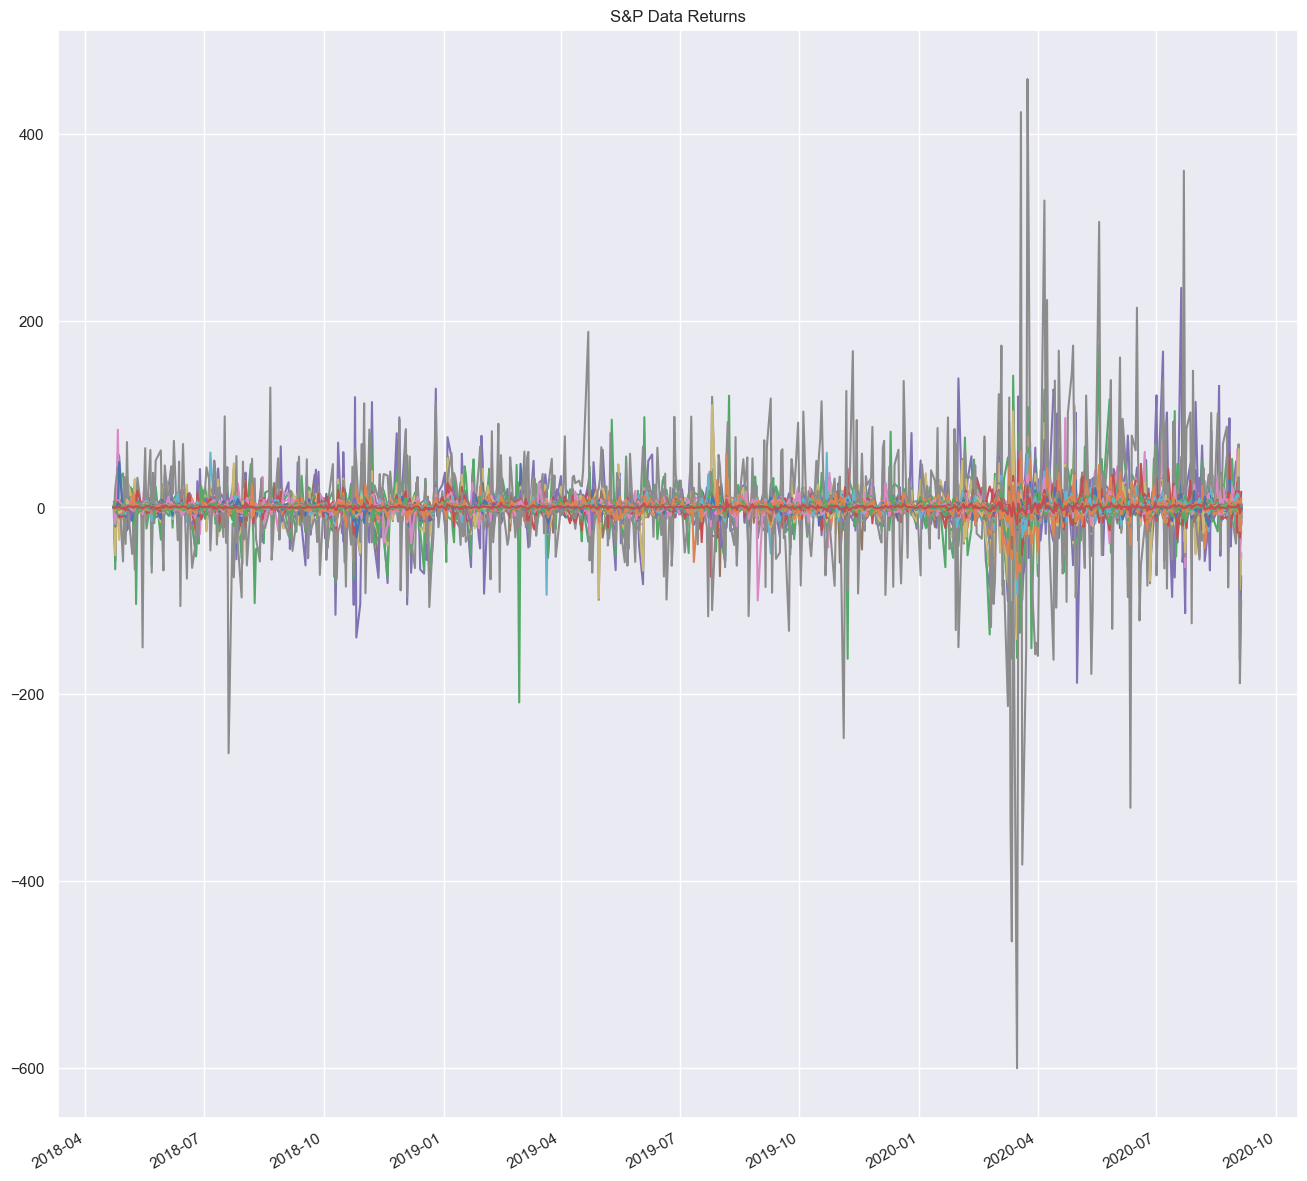

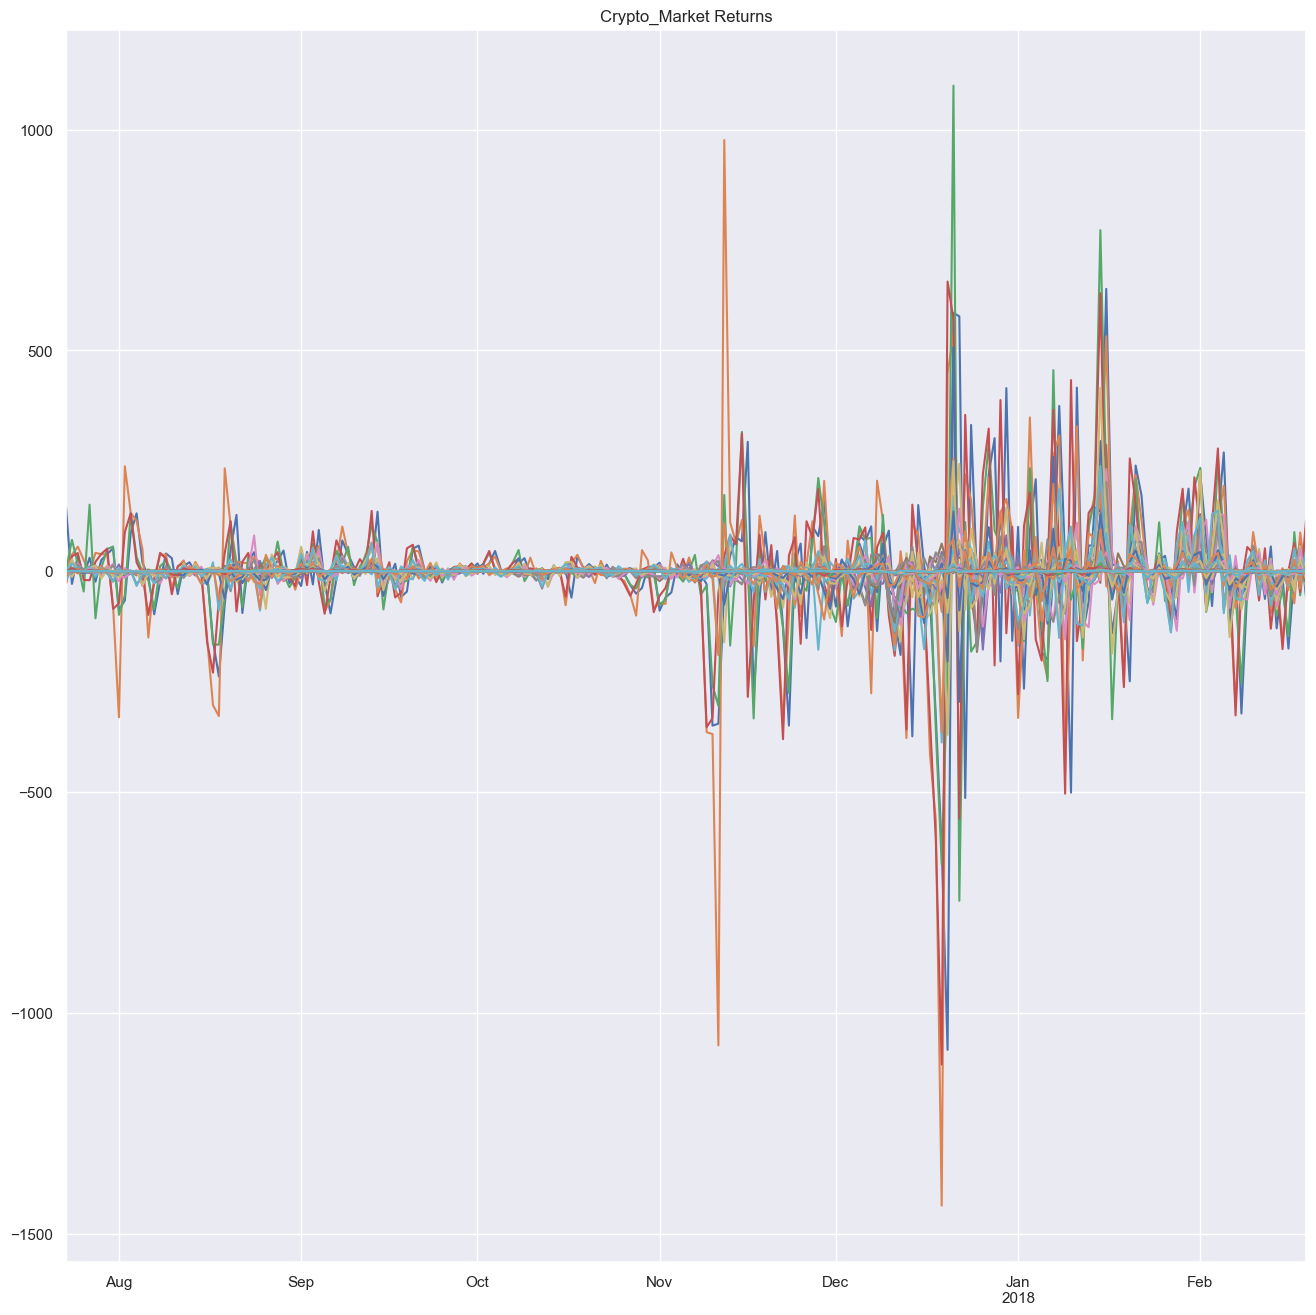

In [11]:
plt.show()

## MAE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


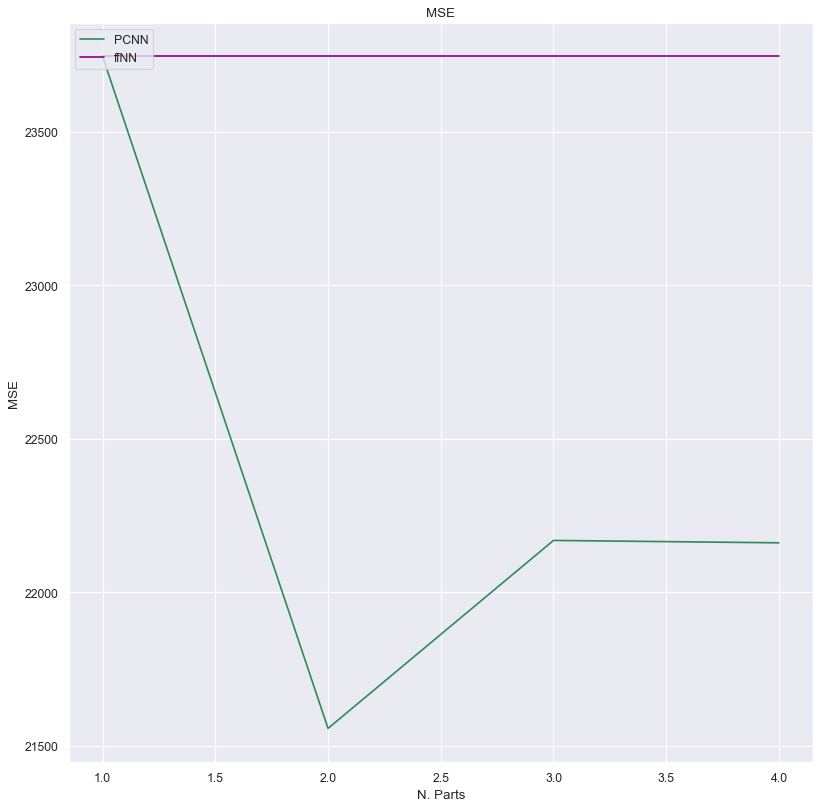

In [12]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE")
plt.xlabel("N. Parts")
plt.ylabel("MSE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MSE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MSE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
# Add Legend
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE_test___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## MAE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


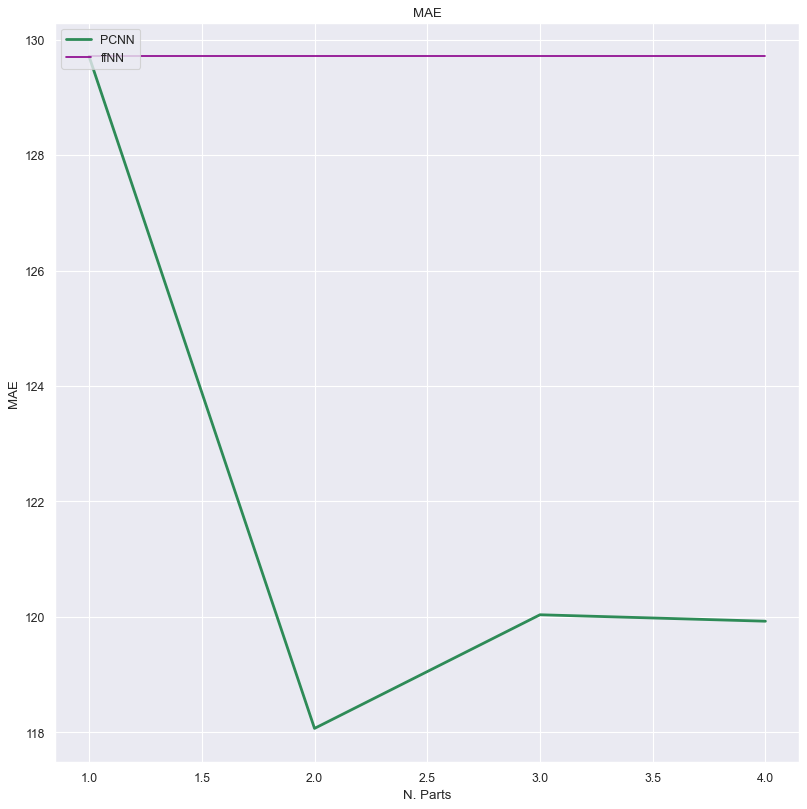

In [23]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MAE")
plt.xlabel("N. Parts")
plt.ylabel("MAE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MAE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MAE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)

# Export #
#--------#
# SAVE Figure to .eps
plt.legend(loc="upper left")
plt.savefig('./outputs/plotsANDfigures/Ablation_MAE___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# L-Time

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


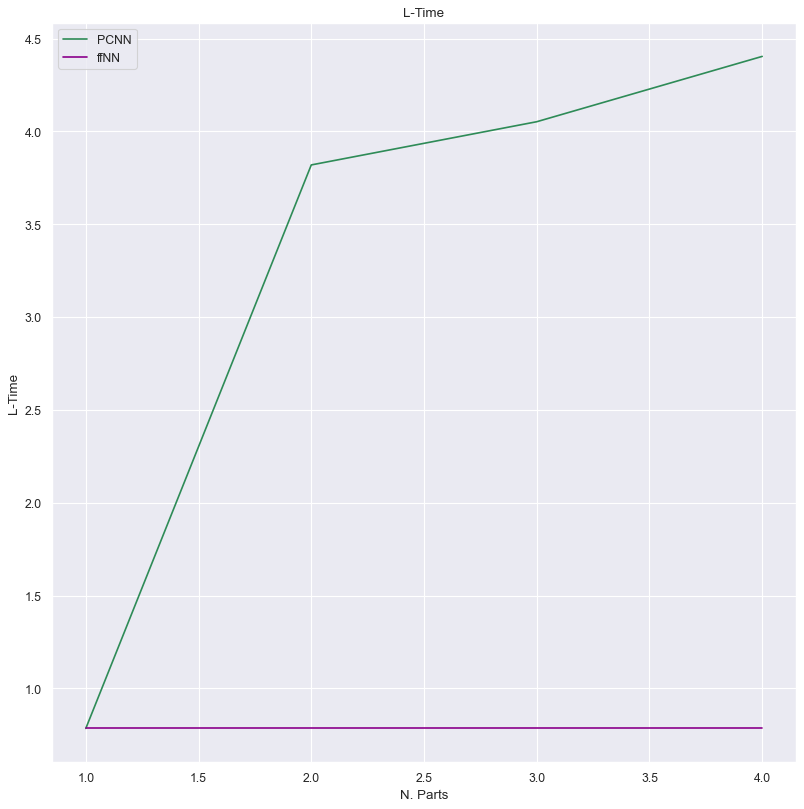

In [14]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("L-Time")
plt.xlabel("N. Parts")
plt.ylabel("L-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5))
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_L_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# P-Times

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


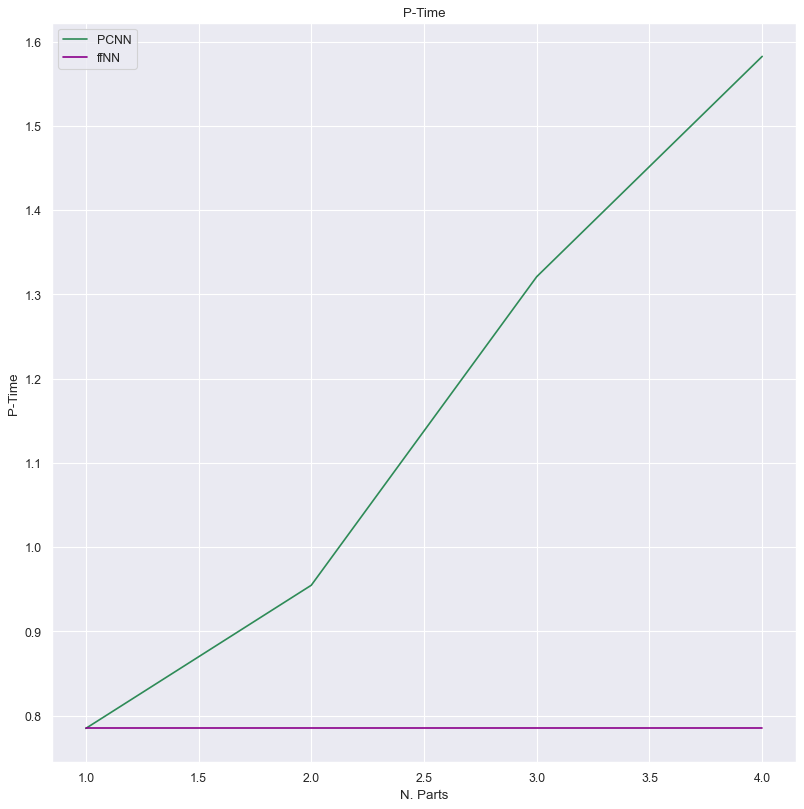

In [15]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("P-Time")
plt.xlabel("N. Parts")
plt.ylabel("P-Time")

# Generate Plots #
#----------------#
# Plot Signal
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_P_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## N-Params

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


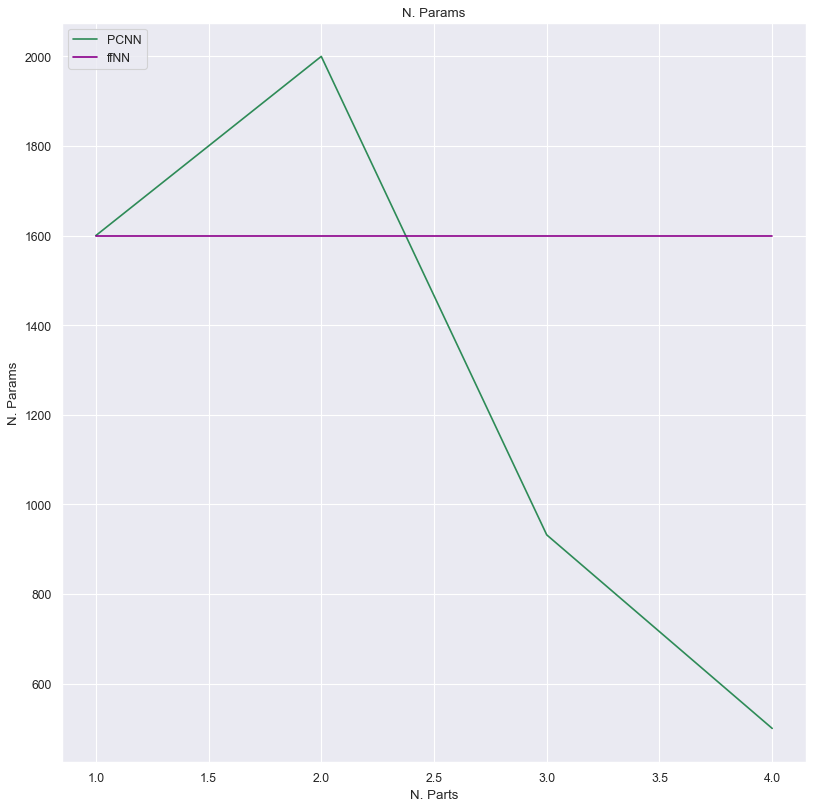

In [16]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("N. Params")
plt.xlabel("N. Parts")
plt.ylabel("N. Params")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_Params,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_N_Params___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Number of Active Neurons Per Input

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


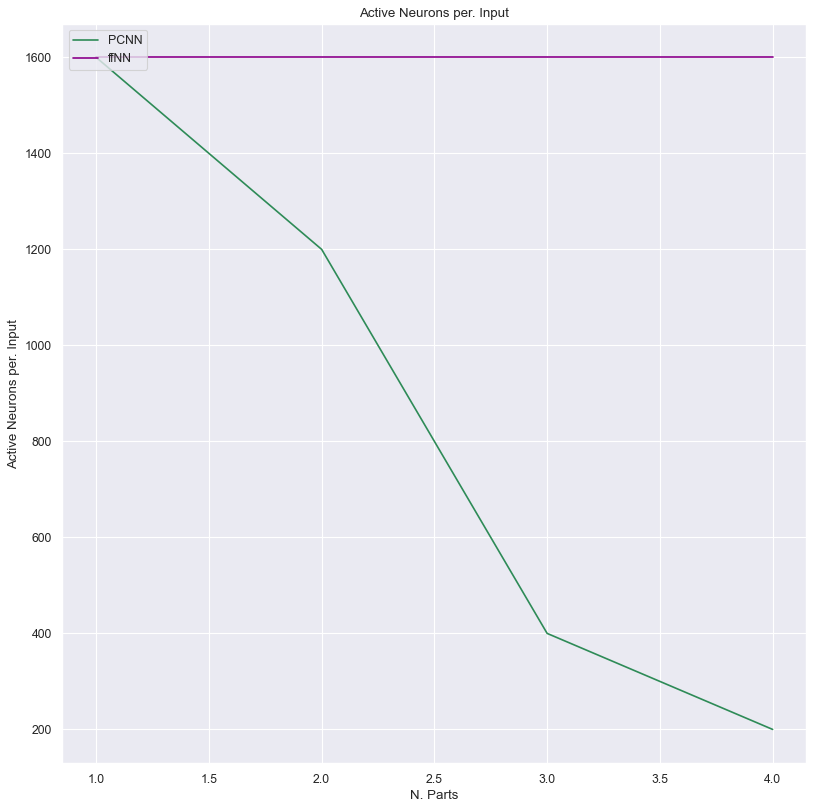

In [17]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Active Neurons per. Input")
plt.xlabel("N. Parts")
plt.ylabel("Active Neurons per. Input")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_per_input,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Active_Neurons_per_input___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Mean Widths for Sub-Pattern Networks

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


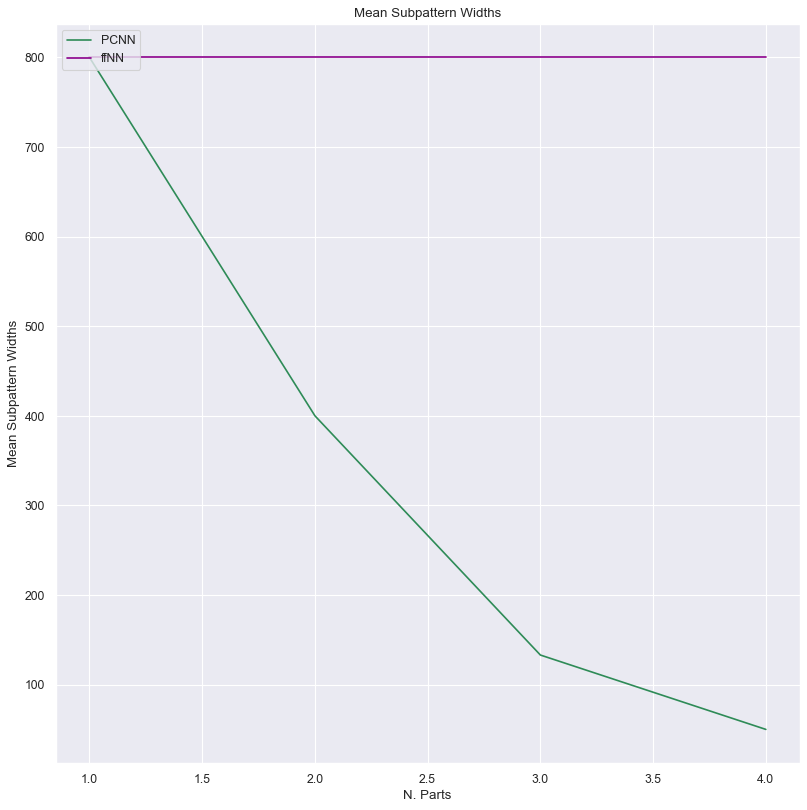

In [18]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Mean Subpattern Widths")
plt.xlabel("N. Parts")
plt.ylabel("Mean Subpattern Widths")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         Width_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Mean_Widths___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

---
# Fin
---

---

---